In [1]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests

## Q 3 Saliency maps and adversarial attacks

### Q3.1 Load a pretrained model from torch vision and compute saliency map for predicted class


In [2]:
import torchvision.models as models

In [3]:
! wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2020-10-16 19:54:41--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.01s   

2020-10-16 19:54:42 (2.58 MB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



In [4]:
import json
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
imagenet_transform = transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                     ])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
make_viewable = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])

pil = transforms.ToPILImage()

In [6]:
url = "https://cdn.wimmel-napkins.com/F/1/AM/g13312895.jpg"
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")

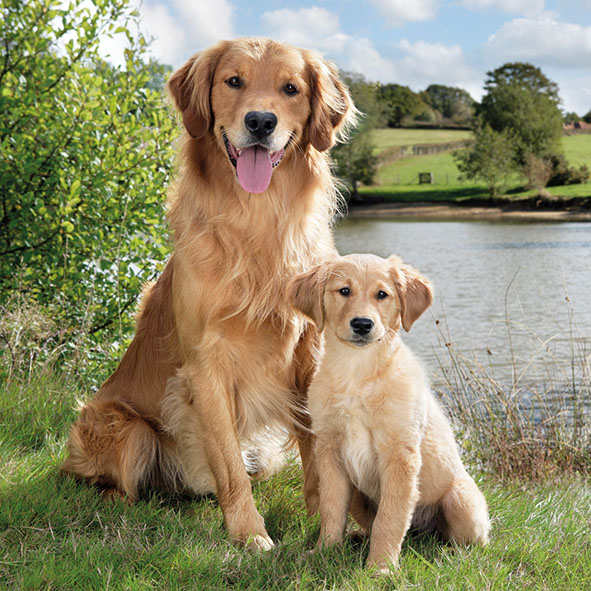

In [7]:
im

### Pass this image through the forward pass of your model to see what the model predicts. For this class, compute the saliency map using the un-normalized score for that class. Details in Sec 3.1 of [1].

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.

IMP: Remember to put the model in eval mode and use un-normalized class scores


In [9]:
def compute_saliency_maps(X, model):
  """
  Compute a class saliency map using the model for image X.
  
  Input:
  - X: Input image, shape is (1, 3, H, W)
  - model: A pretrained CNN that will be used to compute the saliency map.
  
  Returns:
  - saliency: An array of shape (1, H, W) giving the saliency map for the input
    image.
  - predicted_class_id: ID of the class with highest score with respect to 
    which you calculated the saliency map
  """  

  # TODO
  saliency = None 
  
  model.eval() # set model as evaluation mode
  
  X = X.requires_grad_() # enable us to get gradient value from X
  
  model.to(device)

  
  y_pred = model.forward(X)
  

  score, predicted_class_id = torch.max(y_pred, 1)

  score.backward() # do backpropagation to get gradient values
  
  saliency = X.grad.data # take gradient values
  
  saliency = saliency.abs() # get magnitude of it
  
  saliency = saliency.squeeze()
  
  saliency = saliency.cpu().data.numpy()

  return saliency, predicted_class_id

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



tensor([207]) golden_retriever


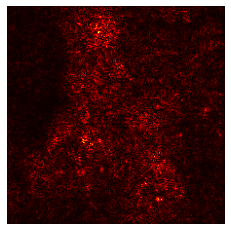

In [10]:
model = models.resnet18(pretrained=True)
X = imagenet_transform(im).unsqueeze(0).to(device)
saliency, predicted_class_id = compute_saliency_maps(X, model)
print(predicted_class_id, idx2label[predicted_class_id])
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

### Q 3.2 Perform an adversarial attack on the network. Make the model misclassify the example as a target class of your choice by performing gradient ascent in the input space. The resulting image should be imperceptibly different to the human eye from the original image.

In [11]:
def make_fooling_image(X, target_y, model, lr=1):
  """
  Generate a fooling image that is close to X, but that the model classifies
  as target_y.
  
  Inputs:
  - X: Input image
  - target_y: An integer in the range [0, 1000)
  - model: Pretrained CNN
  
  Returns:
  - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
  """
  # TODO 
  X = X.requires_grad_()
  model.to(device)

  for i in tqdm (range (200)):

    y_pred = model(X)
    score, predicted_class_id = torch.max(y_pred, 1)
    
   # to minimize the change of image, we will escape for-loop once we get target_id
    if predicted_class_id == target_y: 
      break
  
    score_2 = y_pred [0, target_y] # consider only score of target_y
    score_2.backward() # go backward along target_y id
    
    grad = X.grad.data #  get gradient values
    
    X.data += lr* ( grad/grad.norm()) # change input image by adding gradient values
    X.grad.data.zero_()

  X_fooling = X
  return X_fooling

In [12]:
model = models.resnet18(pretrained=True)
model.eval() # This is important. Can you guess why? Try commenting it out and see the result ;)
X = imagenet_transform(im).unsqueeze(0).to(device)
target_y = 620 # target label 620 in Imagenet corresponds to the "laptop" class

print(f"Predicted label using X :{idx2label[model(X).max(-1)[1].item()]}")
predicted_label_originally = idx2label[model(X).max(-1)[1].item()]

X_fooling = make_fooling_image(X, target_y=target_y, model=model) 

predicted_label_after_fooling = idx2label[model(X_fooling).max(-1)[1].item()]
print(f"Predicted label using X_fooling :{predicted_label_after_fooling }")


Predicted label using X :golden_retriever


Predicted label using X_fooling :laptop


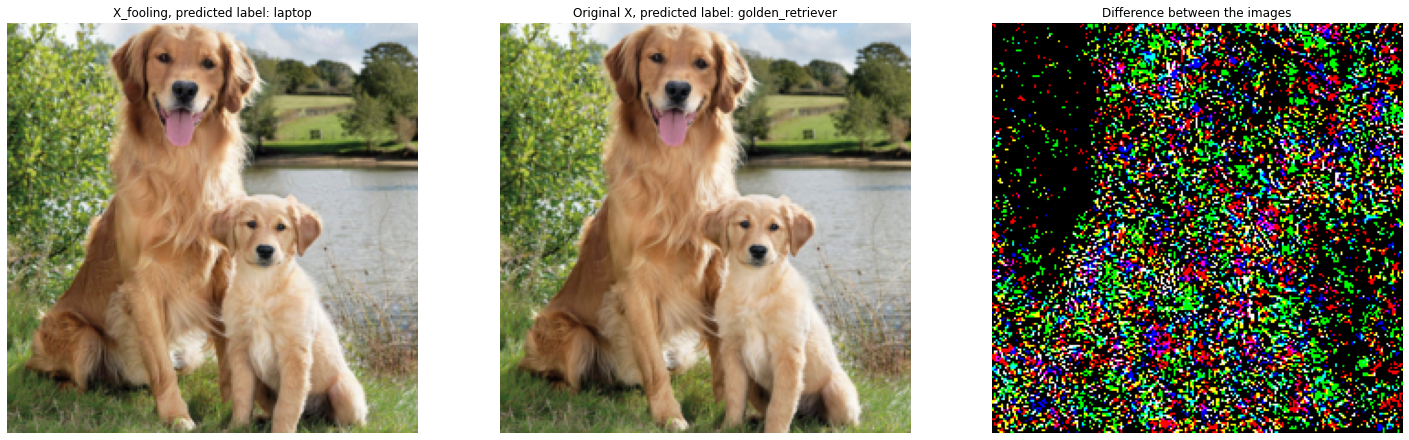

In [13]:
X = imagenet_transform(im).unsqueeze(0).to(device)
# This cell output is what you should expect to see. 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(25)
f.set_figwidth(25)
ax1.imshow(make_viewable(X_fooling.squeeze()))
ax1.title.set_text(f'X_fooling, predicted label: {predicted_label_after_fooling}')
ax2.imshow(make_viewable(X.squeeze()))
ax2.title.set_text(f'Original X, predicted label: {predicted_label_originally}')
ax3.imshow(pil(inv_normalize(X_fooling.squeeze())- inv_normalize(X.squeeze())))
ax3.title.set_text(f'Difference between the images')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

### Q 3.3 Now download a different pre-trained model and see what class it predicts originally for the same model, and if our fooling image is also able to fool this other network. This is an instance of black box adversarial attack where without being able to directly optimize using a given model, you are still able to break it!

Hint: For example, try with VGG19. 

In [14]:
model = models.vgg19(pretrained=True) # impossible
#model = models.resnet18(pretrained=True) # possible
#model = models.resnet34(pretrained=True) # impossible
#model = models.vgg11(pretrained=True) # impossible
model.eval() # This is important. Can you guess why? Try commenting it out and see the result ;)
X = imagenet_transform(im).unsqueeze(0).to(device)
target_y = 620 # target label 620 in Imagenet corresponds to the "laptop" class

print(f"Predicted label using X :{idx2label[model(X).max(-1)[1].item()]}")
predicted_label_originally = idx2label[model(X).max(-1)[1].item()]

y_pred = model.forward(X_fooling)

#X_fooling = make_fooling_image(X, target_y=target_y, model=model) 
score, predicted_label_after_fooling = torch.max(y_pred, 1)

predicted_label_after_fooling = idx2label[model(X_fooling).max(-1)[1].item()]
print(f"Predicted label using X_fooling :{predicted_label_after_fooling }")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Predicted label using X :golden_retriever
Predicted label using X_fooling :golden_retriever


My fooling image cannot fool other networks, vgg19, vg11, ad resnet 34. 
It only fools the resnet 18. 


## Q 4 Localisation 

Here we will see how to use a model that was trained using images at a low resolution for localisation of objects in images at higher resolution. Plot the **classifier response to the last feature map **of the model** before average pooling. **



HINT: You will need to use the "IntermediateLayerGetter" functionality to **extract the last activations before the final avgpool layer** and provide these to the final fully connected layer of the network to get the response. 


In [6]:
from torchvision.models._utils import IntermediateLayerGetter

# Refer to https://github.com/pytorch/vision/blob/master/torchvision/models/_utils.py

imagenet_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")
im = im.resize((int(im.size[0] *2.5), int(im.size[1] * 2.5)))
im

In [14]:
def localisation(X, model):
  """
  Generate a localisation map for the predicted class given an input 
  image and a pretrained CNN
  
  Inputs:
  - X: Input image
  - model: Pretrained CNN
  
  Returns:
  - localisation_map : An 2D heatmap of size 38 X 50
  """
 # import numpy as np
  # TODO
  # we will extract the last activation of neurons 
  mid_getter = IntermediateLayerGetter(model,return_layers={  'layer4':'feat4'}) 
  
  # obtain the predicted class from input image
  model.eval()
  y_pred = model (X)
  _, predicted_class_id = torch.max(y_pred, 1)
  # pass input image through the neural networks before the final avgpool layer.
  out = mid_getter(X)
  for k, v in out.items():
    v = v.squeeze() # get output here
    
    
  # Then extract learned parameters of last fully connected layer from trained model
  model_parames = model.state_dict()
  fc_weight = model_parames['fc.weight']
  fc_bias = model_parames['fc.bias']

  # make dict to import parameters extracted into new neural net
  params = {'0.weight':fc_weight, '0.bias':fc_bias}
  # make new fully connected layer which are the same layer of original model
  fc_net = nn.Sequential(
      nn.Linear(in_features=2048,out_features = 1000, bias = True),
      nn.ReLU() # employ ReLU to make heatmap more clear
  )
  fc_net.load_state_dict(params) # load parameters to new fcc net
  # get response of last feature map to new fcc
  fc_net.eval()
  fc_net.to(device)
  localisation_map = fc_net(v.T)
  localisation_map = localisation_map.T
  localisation_map = localisation_map[predicted_class_id].squeeze() # reduce unnecessary dimension
  return localisation_map

In [15]:
r50 = torchvision.models.resnet50(pretrained=True)
X = imagenet_transform(im).unsqueeze(0).to(device)
print(f"Size of input {X.shape}")
map = localisation(X, r50)


Size of input torch.Size([1, 3, 1200, 1600])


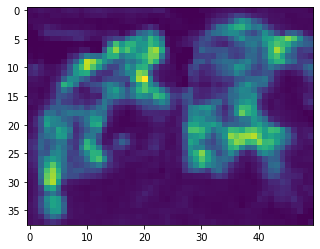

In [16]:

plt.imshow(map.cpu().detach())
plt.show()